In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle
from card_recognition_V1 import get_cards_from_photo, plot_boxes
from card_recognition_V2 import warp_box, get_matches
from calculator import calculator


ImportError: cannot import name 'get_cards_from_photo' from 'card_recognition_V2' (c:\Users\andre\Documents\skol_laptop\6term\ICV\rpoj\card_recognition_V2.py)

In [ ]:
def recognize_value(sus:str):
    possible = ['Two', 'Three', 'Four', 'Five','Six','Seven','Eight','Nine','Ten','Jack','Queen','King','Ace']
    to_be = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']
    return to_be[possible.index(sus)]

In [ ]:
video_path = 'IMG.MOV'  

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


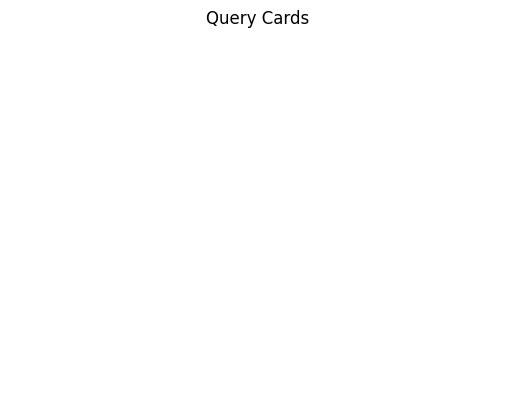

In [ ]:
cap = cv2.VideoCapture(video_path)
video_width = int(cap.get(3))
video_height = int(cap.get(4))

out = cv2.VideoWriter('captured.mp4', cv2.VideoWriter_fourcc(*'mp4v'),30, (video_width, video_height))

gone_cards=[]
flag_to_change = 0
prev = []
frame_count = 0

to_be_texted = None
my_warps = None

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Break the loop if there are no more frames

    frame_count += 1

    if frame_count%15==3:
        current = frame
        warp, boxes = get_cards_from_photo(current,110)
        splttier = np.mean([x[:,1] for x in boxes])
        my_cards_boxes = []
        my_warps = []
        dealers_cards_boxes = []
        dealers_waprs = []
        for i, box in enumerate(boxes):
            if box[0,1]<splttier:
                my_cards_boxes.append(box)
                my_warps.append(warp[i])
            else:
                dealers_cards_boxes.append(box)
                dealers_waprs.append(warp[i])
        labels_path = 'cv_query/ground_labels_V1.txt'
        ground_cards_path = 'cv_query/ground_truth_cards/'
        ground_cards_dirs = sorted(os.listdir(ground_cards_path))
        with open(labels_path, "rb") as fp: 
            cards_labels = pickle.load(fp)
        ground_cards = [plt.imread(ground_cards_path+f'card_ground_{i}.jpg') for i in range(52)]
        # my_index = get_matches(my_warps, ground_cards, plot=False, title_name='5')
        # dealer_index = get_matches(dealers_waprs, ground_cards, plot=False, title_name='5')

        my_cards = [recognize_value(x)+y[0] for (x,y) in detect_cards()]
        dealer_cards = [recognize_value(x)+y[0] for (x,y) in detect_cards()]
        
        probs = calculator(my_cards, dealer_cards, gone_cards)
                
        if len(warp) >= 4:
            if probs == (-2,-2,-2):
                to_be_texted = "You won!"
            elif probs == (-1,-1,-1):
                to_be_texted = "You lose!"
            else:
                to_be_texted = 'probabilities with next card taken: \n'+ \
                                f'overtake: {probs[0]*100:0.1f}%\n' + \
                                f'blackjack: {probs[1]*100:0.1f}%\n' + \
                                f'undertake: {probs[2]*100:0.1f}%\n'

            prev = my_cards + dealer_cards
            flag_to_change = True
        elif len(warp)==0 and flag_to_change:
            gone_cards = gone_cards + prev    
            flag_to_change = False
    
    if to_be_texted:
        for i, line in enumerate(to_be_texted.split('\n')):
            y0, dy = 500, 100
            y = y0 + i*dy
            # cv2.putText(img, line, (50, y ), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
            cv2.putText(frame,line,
                    (500,y),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    3, (0,255,255),5)
        
    if my_warps:
        if len(my_cards)+len(dealer_cards)==4:    
            plot_boxes(frame,my_cards_boxes)
            plot_boxes(frame,dealers_cards_boxes, col=(255,0,0))
            
    cv2.putText(frame,f'cards gone: {len(gone_cards)}',
                (50,frame.shape[0]-50),
                cv2.FONT_HERSHEY_SIMPLEX,
                4,(255,255,255),5)
    out.write(frame)

cap.release()
out.release()